In [64]:
import argparse
from pathlib import Path
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
plt.style.use('tableau-colorblind10')
plt.rcParams["font.family"] = "Arial"
import scienceplots
import pandas as pd
import json
from pprint import pprint
import seaborn as sns
import torch

import torchmetrics
from torchmetrics import PrecisionRecallCurve, ROC
from torchmetrics.functional.classification import binary_auroc, multiclass_auroc, binary_precision_recall_curve, multiclass_precision_recall_curve, confusion_matrix
from torchmetrics.functional.classification import binary_accuracy, multiclass_accuracy, binary_recall, binary_precision, multiclass_recall, multiclass_precision, binary_f1_score, multiclass_f1_score
from torchmetrics.utilities.compute import _auc_compute_without_check, _auc_compute

from utils.utils import get_roc_curve, get_pr_curve, get_confusion_matrix, get_optimal_operating_point

from scipy.stats import bootstrap as scp_bootstrap
from sklearn.metrics import roc_auc_score

import statistics
import logging
import locale
locale.setlocale(locale.LC_ALL, 'en_CA.UTF-8')

'en_CA.UTF-8'

In [3]:
godt_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/GODT_stats_2000_2022.csv'
godt_df = pd.read_csv(godt_path)
godt_df.dropna(subset='TOTAL Kidney Tx', inplace=True)
godt_df.dropna(subset='TOTAL Kidney Tx', inplace=True)
pprint(godt_df)

               REGION      COUNTRY  REPORTYEAR POPULATION  TOTAL Kidney Tx
1              Europe  Switzerland        2015        8.3            322.0
4              Europe       Cyprus        2011        1.1             31.0
6              Europe       Cyprus        2016        1.2             19.0
7             America       Brazil        2010      195.4           4660.0
13            America       Brazil        2015      207.8           5510.0
...               ...          ...         ...        ...              ...
3631  South-East Asia     Thailand        2018       69.2            668.0
3632          America       Canada        2014       35.5           1336.0
3633           Europe      Iceland        2018        0.3              9.0
3634           Africa      Nigeria        2008      151.5             14.0
3635          America         Peru        2016       31.8            162.0

[1871 rows x 5 columns]


In [4]:
def get_population(region, year):
    if region == 'Global':
        pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df['TOTAL Kidney Tx']!='']['POPULATION'].values
    else: 
        pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df.REGION==region]['POPULATION'].values
    pop = [locale.atof(x) for x in pop]
    return pop

In [5]:
def get_n_transplant(region, year):
    if region == 'Global':
        n_ktx = godt_df.loc[godt_df.REPORTYEAR==year]['TOTAL Kidney Tx'].values
    else:
        n_ktx = godt_df.loc[godt_df.REPORTYEAR==year][godt_df.REGION==region]['TOTAL Kidney Tx'].values
    return n_ktx


    

In [6]:
#Europe
eu_pop_2022 = get_population('Europe', 2022)
eu_nktx_2022 = get_n_transplant('Europe', 2022)
eu_pop_2012 = get_population('Europe', 2012)
eu_nktx_2012 = get_n_transplant('Europe', 2012)
eu_pop_2021 = get_population('Europe', 2021)
eu_nktx_2021 = get_n_transplant('Europe', 2021)

eu_rate_2022 = sum(eu_nktx_2022) / sum(eu_pop_2022)
eu_rate_2012 = sum(eu_nktx_2012) / sum(eu_pop_2012)
eu_rate_2021 = sum(eu_nktx_2021) / sum(eu_pop_2021)

rate_increase_10 = (eu_rate_2022 - eu_rate_2012) / eu_rate_2012
rate_increase_1 = (eu_rate_2022 - eu_rate_2021) / eu_rate_2021
print(rate_increase_10)
print(rate_increase_1)


0.29181575093256873
0.05177938301461827


/tmp/ipykernel_3076611/1648641371.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df.REGION==region]['POPULATION'].values
/tmp/ipykernel_3076611/567678976.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_ktx = godt_df.loc[godt_df.REPORTYEAR==year][godt_df.REGION==region]['TOTAL Kidney Tx'].values
/tmp/ipykernel_3076611/1648641371.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df.REGION==region]['POPULATION'].values
/tmp/ipykernel_3076611/567678976.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_ktx = godt_df.loc[godt_df.REPORTYEAR==year][godt_df.REGION==region]['TOTAL Kidney Tx'].values
/tmp/ipykernel_3076611/1648641371.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = godt_df.loc[godt_df.REPORTYEAR==year

In [7]:
#Global

global_pop_2022 = sum(get_population('Global', 2022))*1e6
global_nktx_2022 = get_n_transplant('Global', 2022)
global_pop_2021 = sum(get_population('Global', 2021))*1e6
global_nktx_2021 = get_n_transplant('Global', 2021)
global_pop_2012 = sum(get_population('Global', 2012))*1e6
global_nktx_2012 = get_n_transplant('Global', 2012)
global_pop_2020 = sum(get_population('Global', 2020))*1e6
global_nktx_2020 = get_n_transplant('Global', 2020)
print(sum(global_nktx_2022))
# print(sum(global_pop_2012))
print(global_pop_2012)

global_rate_2012 = sum(global_nktx_2012) / global_pop_2012
global_rate_2020 = sum(global_nktx_2020) / global_pop_2020
global_rate_2021 = sum(global_nktx_2021) / global_pop_2021
global_rate_2022 = sum(global_nktx_2022) / global_pop_2022
# rate_increase_10 = (eu_rate_2022 - eu_rate_2012) / eu_rate_2012

rate_increase_1 = (global_rate_2022 - global_rate_2021) / global_rate_2021
rate_increase_10 = (global_rate_2022 - global_rate_2012) / global_rate_2012
rate_increase_2 = (global_rate_2022 - global_rate_2020) / global_rate_2020


print(rate_increase_1)  
print(rate_increase_10)
print((1+rate_increase_10)**(1/10))
print((1+rate_increase_2)**(1/2))
# print(rate_increase_2)
# print(global_rate_2022)

102090.0
6218799999.999998
0.10914220330029509
0.3690573459570692
1.0319108146753893
1.1486570098493063


/tmp/ipykernel_3076611/1648641371.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df['TOTAL Kidney Tx']!='']['POPULATION'].values
/tmp/ipykernel_3076611/1648641371.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df['TOTAL Kidney Tx']!='']['POPULATION'].values
/tmp/ipykernel_3076611/1648641371.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df['TOTAL Kidney Tx']!='']['POPULATION'].values
/tmp/ipykernel_3076611/1648641371.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop = godt_df.loc[godt_df.REPORTYEAR==year][godt_df['TOTAL Kidney Tx']!='']['POPULATION'].values


In [8]:
# 1 year increment sum of ktx over 10 years
# source: https://population.un.org/wpp/
population_csv = pd.read_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/world_population_projection.csv')
global_population = [8045311447, 8118835999, 8191988453, 8264364509, 8335977671, 8406828792, 8476889391, 8546141327, 8614532745, 8682091984] # 2023 -> 2032 #7975105156, 
# low_global_population = [8023852000, 8083067400, 8141883000, 8199887000, 8252717000, 8300369000, 8347165700, 8393068500, 8438011000, 8479031300]
# high_global_population = [8066769400, 8154602000, 8242091500, 8328843000, 8419249000, 8513318400, 8606672000, 8699312000, 8791199000, 8885350000]

low_global_population = list(population_csv['Low Population'])
high_global_population = list(population_csv['High Population'])
# print(low_global_population)
# print(len(low_global_population))
current_rate = global_rate_2022
print(current_rate)
low_total_ktx = 0
high_total_ktx = 0
low_ktx = []
high_ktx = []
# current_nktx = sum(eu_nktx_2022)
for i in range(len(low_global_population)):
    # low_current_population = low_global_population[i]
    # high_current_population = high_global_population[i]
    # current_rate = current_rate * (((1+rate_increase_10)**(1/10))) # assuming rate increases the same every year
    # current_rate = current_rate * (1+(rate_increase_1)) # assuming rate increases the same every year
    current_rate = current_rate * ((1+rate_increase_2)**(1/2)) # assuming rate increases the same every year
    # print(current_rate)
    # low_ktx = low_current_population * current_rate
    # low_total_ktx +=low_current_population * current_rate
    # high_total_ktx += high_current_population * current_rate
    low_ktx.append(low_global_population[i] * current_rate)
    high_ktx.append(high_global_population[i] * current_rate)
    # current_nktx = current_nktx * (1+rate_increase_1)


# print('ktx over 10 years: ', total_ktx)
print(sum(low_ktx))
# print(high_ktx)

1.712488467667533e-05
48644340440.678314


In [9]:
def mortality_2032(model, country_ratio):

    model_co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
    model_co2_df = pd.read_csv(model_co2_path)
    model_co2 = model_co2_df.loc[model_co2_df.MODEL == model]['CO2eq'].values[0]
    
    # model_co2eq = 0.035 #(g) TransMIL+RetCCL, no grad, 3 Stains
    model_co2 = model_co2 * country_ratio
    low_total_co2 = sum(low_ktx) * model_co2 
    high_total_co2 = sum(high_ktx) * model_co2 
    # print(total_co2, 'tons')
    mortality_co2 = 4400*1e6 #tons
    # print(mortality_co2)
    # killed = total_co2 / mortality_co2
    # print(killed, 'people killed by 2100 due to CO2eq emissions.')
    return (low_total_co2/mortality_co2 , high_total_co2/mortality_co2)

In [10]:
renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)
country_list = list(re_ratio.Country)
germany_ratio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
ratio_list = [germany_ratio/re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0] for c in country_list]
print(ratio_list)
print(re_ratio)
print(list(zip(country_list, ratio_list)))

[1.0, 1.8732394366197185, 2.156756756756757, 1.9368932038834954, 1.4301075268817203, 0.9827586206896551, 1.0283505154639176, 0.4235668789808918, 0.7808219178082192, 3.325, 3.022727272727273, 0.5973053892215568, 1.1465517241379313, 0.7823529411764706, 1.33, 5.115384615384616]
        Country  renewableRatio
0       Germany           0.399
1       Belgium           0.213
2   Netherlands           0.185
3        France           0.206
4       England           0.279
5         Spain           0.406
6         Italy           0.388
7        Norway           0.942
8        Sweden           0.511
9         Czech           0.120
10       Poland           0.132
11      Austria           0.668
12      Ireland           0.348
13     Portugal           0.510
14           US           0.300
15        India           0.078
[('Germany', 1.0), ('Belgium', 1.8732394366197185), ('Netherlands', 2.156756756756757), ('France', 1.9368932038834954), ('England', 1.4301075268817203), ('Spain', 0.982758620689655

In [11]:
paper_outdir = '/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures'



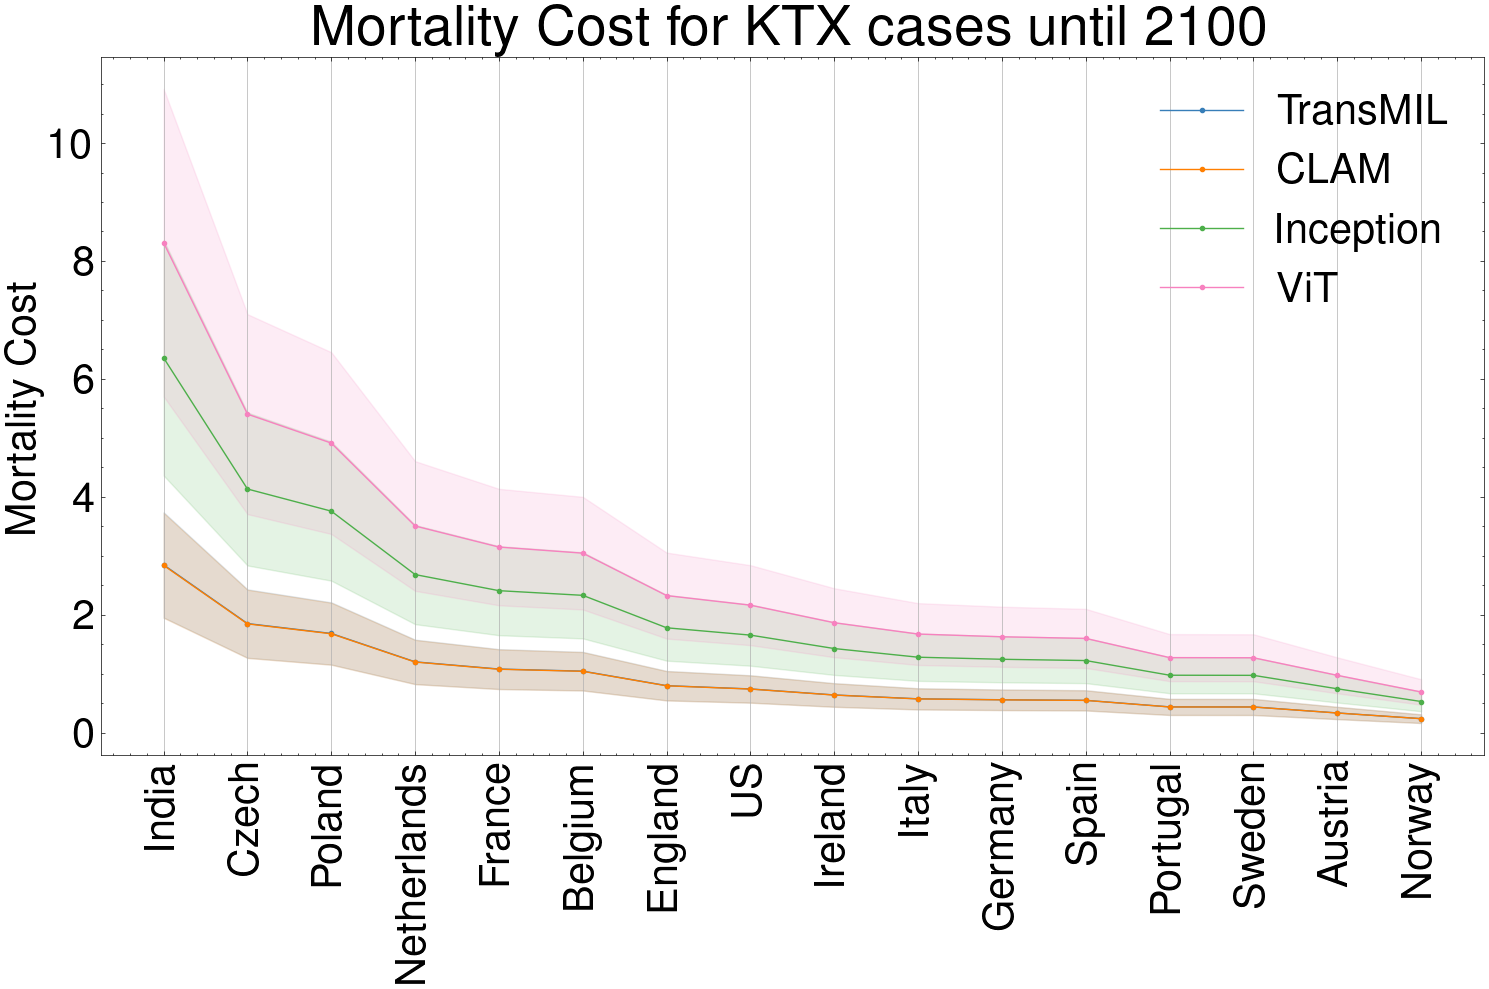

In [84]:
# if all kidney transplant cases worldwide were pre-screened with our model in one country 
COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, f'{y[i]:.2f}', ha = 'center', fontsize=10)
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
line_styles = ['o-','o--','o:','o-.', 'o-']

with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(figsize=(15,10)) #
    legend_list = []
    for i, model in enumerate(model_list): #
        # if model == 'CLAM':
        #     continue
        # model = 'TransMIL'
        color = COLOR_MAP[i]
        low_kill_list = [mortality_2032(model, x)[0] for x in ratio_list]
        high_kill_list = [mortality_2032(model, x)[1] for x in ratio_list]
        mean_kill_list = np.mean(np.array([low_kill_list, high_kill_list]), axis=0)
        sorted_indices = np.argsort(-mean_kill_list)
        low_y = [low_kill_list[i] for _, i in zip(low_kill_list, sorted_indices)]
        high_y = [high_kill_list[i] for _, i in zip(high_kill_list, sorted_indices)]
        mean_y = [mean_kill_list[i] for _, i in zip(mean_kill_list, sorted_indices)]
        
        
        x = [country_list[i] for _, i in zip(country_list, sorted_indices)]
        
        p, = ax.plot(x, mean_y, 'o-', color=color)
        ax.fill_between(x, low_y, high_y, color=color, alpha=.15)
        # addlabels(x, y)
        # ax.legend(model, fontsize=20)
        legend_list.append(p)
        
    # for i in range(len(country_list)):
    #     print(country_list[i])
    #     print(ratio_list[i])
    #     killed = mortality_2032(model, ratio_list[i])
    #     print(killed)
    #     line1 = ax.plot(country_list, kill_list,  line_styles[i], label=model_name, color=f'C{i+1}', ms=10)
    plt.legend(legend_list, ['TransMIL','CLAM', 'Inception', 'ViT'], fontsize=30, loc='upper right')
    plt.grid(visible=True, which='major', axis='x')
    plt.ylabel('Mortality Cost', fontsize= 30)
    plt.xticks(rotation=90, ha='center', fontsize=30)
    # plt.xticks(rotation=45, ha='right', fontsize=20)

    plt.yticks(fontsize=30)
    # plt.xticks(ha='right', fontsize=20)
    plt.title(f'Mortality Cost for KTX cases until 2100', fontsize=40)
    # plt.show()
    plt.tight_layout()
    plt.savefig(f'{paper_outdir}/mort_2100_per_country.png', dpi=400)
    plt.savefig(f'{paper_outdir}/mort_2100_per_country.svg', dpi=400)
    plt.show()

In [13]:
# if all kidney transplant cases worldwide were pre-screened with our model in one country 
COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, f'{y[i]:.2f}', ha = 'center', fontsize=10)
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
line_styles = ['o-','o--','o:','o-.', 'o-']
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(figsize=(10,10)) #
    for i, model in enumerate(model_list): #
        if model == 'CLAM':
            continue
        # model = 'TransMIL'
        color = COLOR_MAP[i]
        kill_list = [mortality_2032(model, x) for x in ratio_list]
        sorted_indices = np.argsort(kill_list)
        # print(kill_list)
        # print(country_list)
        # print(sorted_indices)
        y = [kill_list[i] for _, i in zip(kill_list, sorted_indices)]
        x = [country_list[i] for _, i in zip(country_list, sorted_indices)]
        
        ax.plot(x, y, 'o-', color=color)
        addlabels(x, y)
        
    # for i in range(len(country_list)):
    #     print(country_list[i])
    #     print(ratio_list[i])
    #     killed = mortality_2032(model, ratio_list[i])
    #     print(killed)
    #     line1 = ax.plot(country_list, kill_list,  line_styles[i], label=model_name, color=f'C{i+1}', ms=10)
    plt.legend(['TransMIL/CLAM', 'Inception', 'ViT'], fontsize=20)
    plt.grid(visible=True, which='major', axis='x')
    plt.ylabel('People killed', fontsize= 20)
    plt.xticks(rotation=90, ha='center', fontsize=20)
    # plt.xticks(rotation=45, ha='right', fontsize=20)

    plt.yticks(fontsize=15)
    # plt.xticks(ha='right', fontsize=20)
    plt.title(f'Mortality Cost for 10 year KTX cases', fontsize=30)
    # plt.show()
    plt.tight_layout()
    plt.savefig(f'{paper_outdir}/mort_10y_per_country.png', dpi=400)
    plt.savefig(f'{paper_outdir}/mort_10y_per_country.svg', dpi=400)
    plt.show()



TypeError: only integer scalar arrays can be converted to a scalar index

Error in callback <function _draw_all_if_interactive at 0x7fca6f167f70> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x1000 with 1 Axes>

[20.901665628727645, 20.84108109067336, 46.71067883985221, 61.06921435871729]


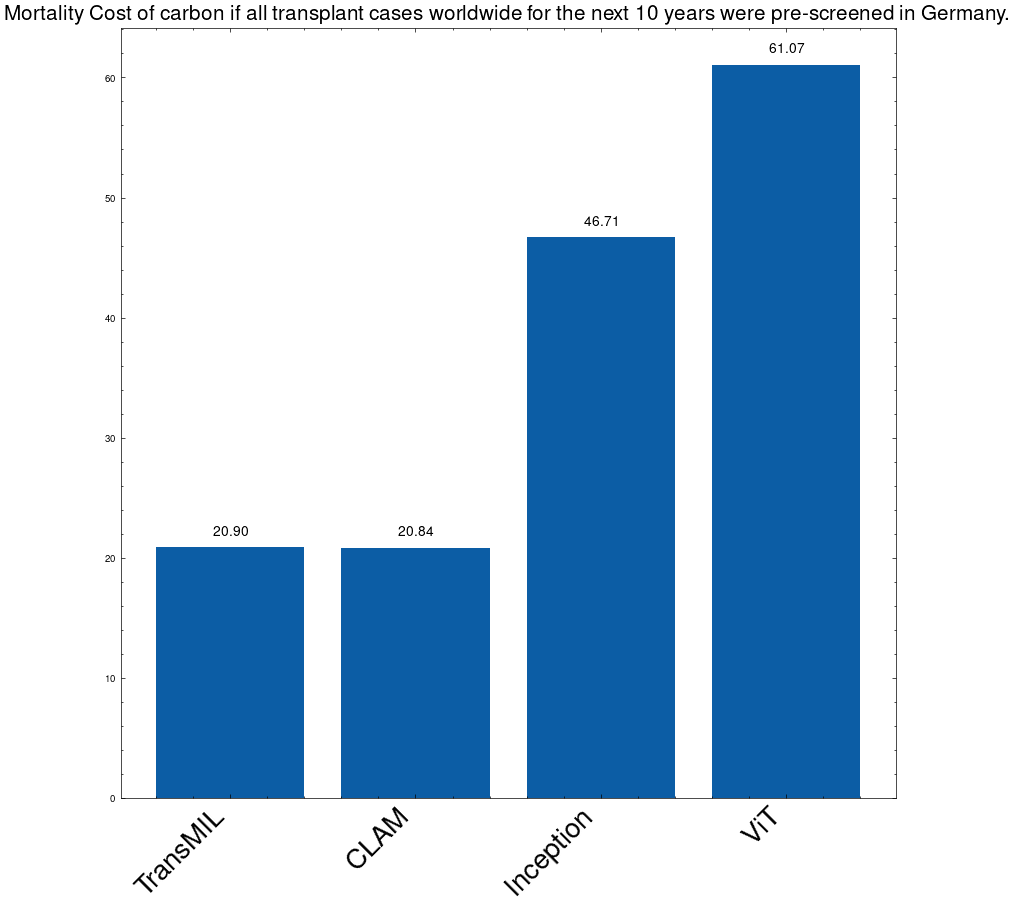

In [ ]:

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, f'{y[i]:.2f}', ha = 'center', fontsize=15)

line_styles = ['o-','o--','o:','o-.']
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT'] #, 'PALM'
# for model in ['TransMIL', 'CLAM', 'Inception', 'ViT', 'PALM']:
kill_list = [mortality_2032(model, 1.0) for model in model_list]
print(kill_list)
with plt.style.context(['science', 'nature']):
    # model = 'TransMIL'
    fig, ax = plt.subplots(figsize=(10,10))
    # kill_list = [mortality_2032(model, x) for x in ratio_list]
    
    ax.bar(model_list, kill_list)
    addlabels(model_list, kill_list)
    # for i in range(len(country_list)):
    #     print(country_list[i])
    #     print(ratio_list[i])
    #     killed = mortality_2032(model, ratio_list[i])
    #     print(killed)
    #     line1 = ax.plot(country_list, kill_list,  line_styles[i], label=model_name, color=f'C{i+1}', ms=10)
    plt.xticks(rotation=45, ha='right', fontsize=20)
    plt.title(f'Mortality Cost of carbon if all transplant cases worldwide for the next 10 years were pre-screened in Germany.', fontsize=15)
    plt.show()

{'coal': 0.2803573812718099, 'wind': 0.2253669530721031, 'nuclear': 0.15369755956307254, 'gas': 0.11058637768023172, 'biomass': 0.08308318134527178, 'solar': 0.0785054519613461, 'hydro': 0.05267578934083479, 'other*': 0.015728460418098465}
['coal\n28.0%', 'wind\n22.5%', 'nuclear\n15.4%', 'gas\n11.1%', 'biomass\n8.3%', 'solar\n7.9%', 'hydro\n5.3%', 'other*\n1.6%']
[0.2803573812718099, 0.2253669530721031, 0.15369755956307254, 0.11058637768023172, 0.08308318134527178, 0.0785054519613461, 0.05267578934083479, 0.015728460418098465]
1.0000011546527685


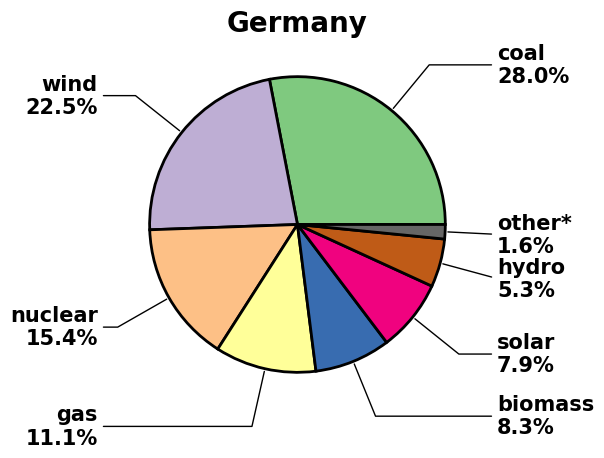

In [ ]:
### Pie Chart Germany Energy Mix


# import matplotlib.pyplot as plt

energy_mix_dict = {
    
    # 'battery_discharge': 0.0,
    'biomass': 0.08308318134527178,
    'coal': 0.2803573812718099,
    'gas': 0.11058637768023172,
    # 'geothermal': 0.0003312767138253547,
    'hydro': 0.036427024225577254 + 0.016248765115257538, #+ hydro_discharge
    # 'hydro_discharge': 0.016248765115257538,
    'nuclear': 0.15369755956307254,
    # 'oil': 0.007445342383857422,
    'solar': 0.0785054519613461,
    # 'unknown': 0.00795184132041569,
    'wind': 0.2253669530721031,
    'other*': 0.007445342383857422 + 0.00795184132041569 + 0.0003312767138253547 #oil + unknown + geothermal

}

sorted_dict = dict(sorted(energy_mix_dict.items(), key=lambda item: item[1], reverse=True))
# labels = sorted_dict.keys()
print(sorted_dict)
labels = [f'{k}\n{v*100:.1f}%' for k,v in sorted_dict.items()]
values = sorted_dict.values()
values = [v for v in values]

print(labels)
print(values)
print(sum(values))

# def func(x, labels):
#     # a  = np.round(, 0)
#     # a = 
#     return f'{x*100:.1f}%'
# sizes = [15, 30, 45, 10]

fig, ax = plt.subplots() #figsize=(7,7)
wedges, texts = ax.pie(values, 
                #   labels=labels, 
                  colors=plt.cm.Accent.colors, 
                  labeldistance=1.2, 
                  wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'antialiased':True},
                  )
for t in texts:
    t.set_horizontalalignment('left')
    
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
    #   
    # bbox=bbox_props, 
    zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, fontsize=15, fontweight='bold', **kw)
    
plt.title('Germany', fontweight='bold', fontsize=20)

# img = ax.imshow(cmap='RdBu')
plt.savefig(f'{paper_outdir}/DE_mix_pie.png', dpi=400)
plt.savefig(f'{paper_outdir}/DE_mix_pie.svg', dpi=400)
plt.show()





[1.0, 1.8732394366197185, 2.156756756756757, 1.9368932038834954, 1.4301075268817203, 0.9827586206896551, 1.0283505154639176, 0.4235668789808918, 0.7808219178082192, 3.325, 3.022727272727273, 0.5973053892215568, 1.1465517241379313, 0.7823529411764706, 1.33, 5.115384615384616]
model_co2:  0.0345


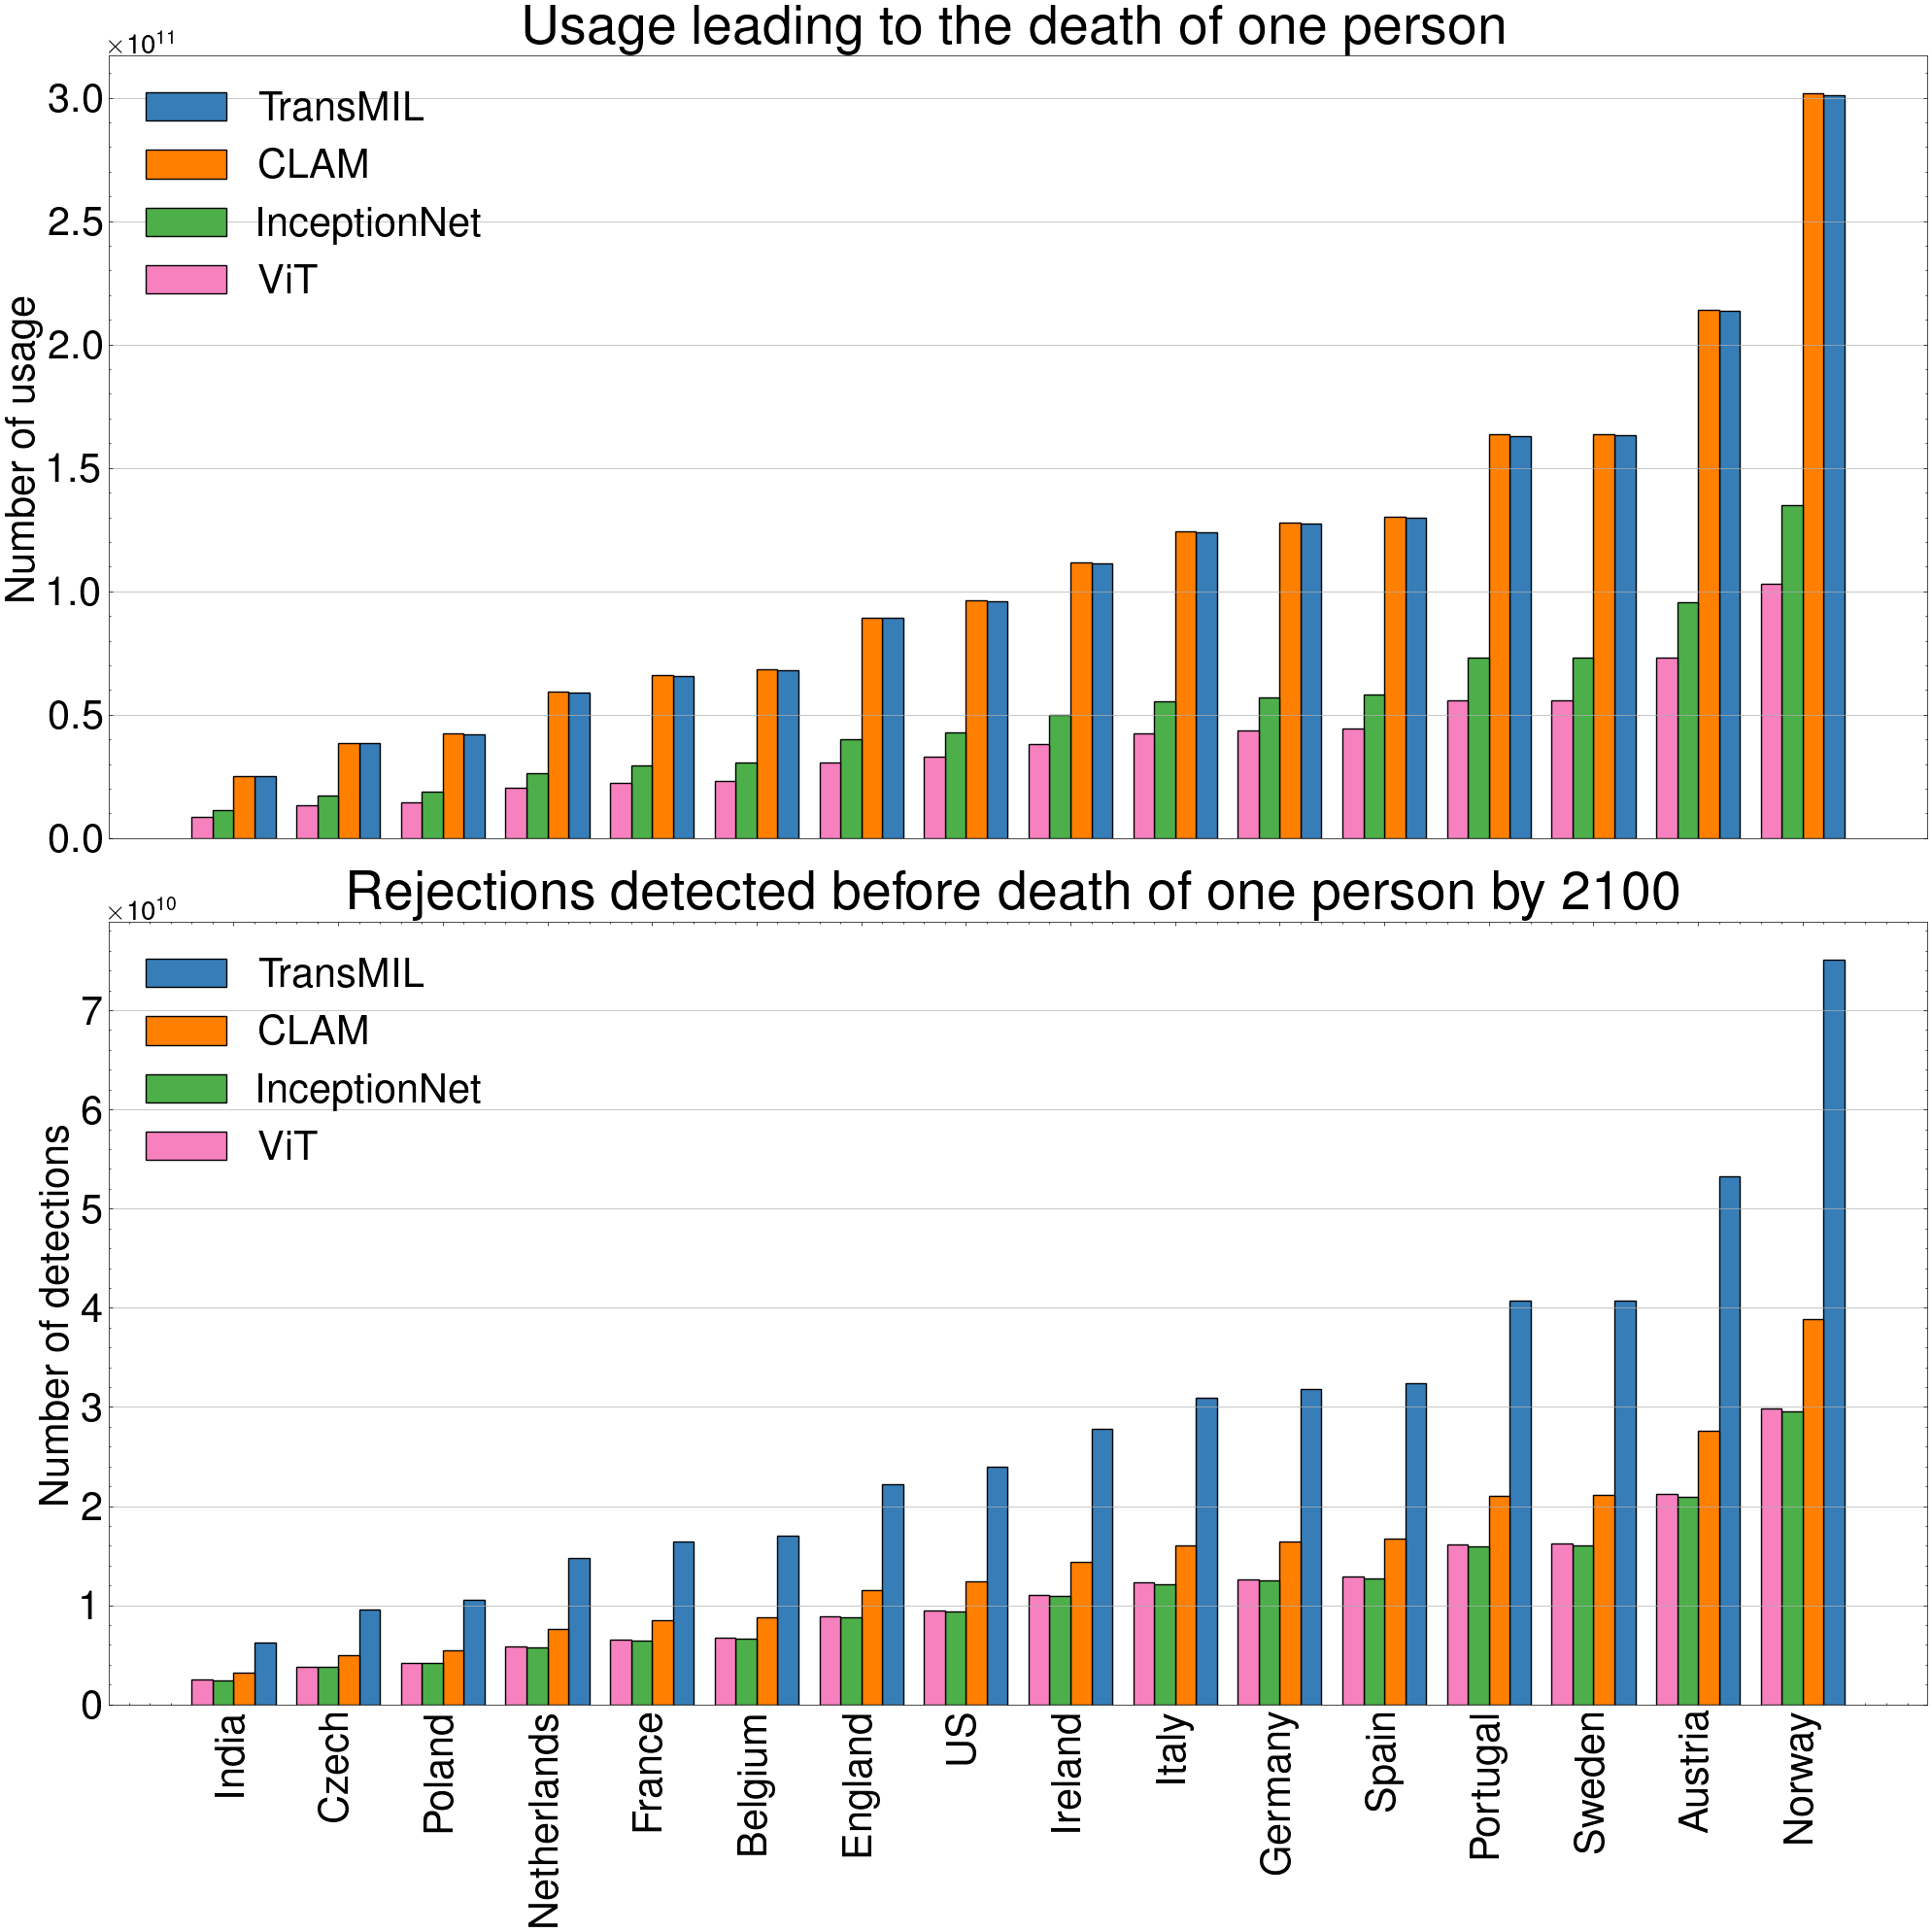

In [85]:
### Mortality Rate for all countries with 301100.5775 times usage 
# ref_usage = 301100.5775 # Norway

COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

ref_co2 = 0.0345 # TransMIL+RetCCL, 3 slides, no grad 
mortality_co2 = 4400 #4400 tons / Person
print(ratio_list)
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
model_co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
model_co2_df = pd.read_csv(model_co2_path)
model_co2_list = [model_co2_df.loc[model_co2_df['MODEL'] == m]['CO2eq'].values[0] for m in model_list]

usage = [(mortality_co2 / (model_co2_list[0] * r))  for r in ratio_list] #get number of usage
sorted_list = [(x, y) for y, x in sorted(zip(usage, country_list))]
sorted_countries = [x[0] for x in sorted_list]
sorted_usage = [x[1] for x in sorted_list]
x_ticks = np.arange(len(sorted_usage), dtype=int)
# for r in ratio_list: 
#     print(0.0345*r)

with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(2,1, figsize=(20,20))
    for i in range(len(model_list)):
        m_co2 = model_co2_list[i]
        # precision = precision_list[i]
        usage = [(mortality_co2 / (m_co2 * r))  for r in ratio_list] #get number of usage
        sorted_usage = [x*1e6 for x in sorted(usage)]
        ax[0].bar([x-(i*0.2-0.3) for x in x_ticks], sorted_usage, width=0.2, color=COLOR_MAP[i], edgecolor='black')
        
    ax[0].set_title('Usage leading to the death of one person', fontsize=40)
    ax[0].legend(['TransMIL', 'CLAM', 'InceptionNet', 'ViT'], fontsize=30, frameon=False)
    ax[0].set_xticks([])
    ax[0].set_ylabel('Number of usage', fontsize=30) # (Million)
    # ax[0].set_yticks(fontsize=15)
    ax[0].grid(visible=True, which='major', axis='y')
    ax[0].yaxis.get_offset_text().set_fontsize(20)
    # ax[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0e'))

    ax[0].tick_params(axis='y', labelsize=30)

    ## 2nd PLOT


    precision_list = [0.6875, 0.3559, 0.2701, 0.2733]
    model_co2 = model_co2_list[0]

    rejection_prevalence = 0.363 # 47 of 173 are rejections in Aachen KTX
    print('model_co2: ', model_co2)

    usage = [(mortality_co2 / (model_co2 * r))  for r in ratio_list] #get number of usage
    sorted_list = [(x, y) for y, x in sorted(zip(usage, country_list))]
    sorted_countries = [x[0] for x in sorted_list]
    sorted_usage = [x[1] for x in sorted_list]
    x_ticks = np.arange(len(sorted_usage), dtype=int)
    for i in range(len(model_list)):
        m_co2 = model_co2_list[i]
        precision = precision_list[i]
        usage = [(mortality_co2 / (m_co2 * r))  for r in ratio_list] #get number of usage
        sorted_usage = [x[1] for x in sorted_list]
        
        y = [x * rejection_prevalence * precision * 1e6 for x in sorted_usage]
        ax[1].bar([x-(i*0.2-0.3) for x in x_ticks], y, width=0.2, color=COLOR_MAP[i], edgecolor='black')



    ax[1].set_title('Rejections detected before death of one person by 2100', fontsize=40)
    ax[1].legend(['TransMIL', 'CLAM', 'InceptionNet', 'ViT'], fontsize=30, frameon=False)
    ax[1].set_ylabel('Number of detections', fontsize=30) # (Million)
    # ax[0].set_yticks(fontsize=15)
    ax[1].grid(visible=True, which='major', axis='y')
    ax[1].set_xticks(x_ticks, sorted_countries, rotation=90, ha='center', fontsize=30)
    # ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0), useLocale=True)
    ax[1].yaxis.get_offset_text().set_fontsize(20)
    # ax[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0e'))


    ax[1].tick_params(axis='y', labelsize=30)


    plt.savefig(f'{paper_outdir}/combined_mortality_usage.png', dpi=400)
    plt.savefig(f'{paper_outdir}/combined_mortality_usage.svg', dpi=400)
    plt.tight_layout()
    plt.show()


In [1]:
COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
# model_list = ['TransMIL', 'CLAM']
model_co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
model_co2_df = pd.read_csv(model_co2_path)
model_co2_list = [model_co2_df.loc[model_co2_df['MODEL'] == m]['CO2eq'].values[0] for m in model_list]

mortality_co2 = 4400 # tons CO2
precision_list = [0.6875, 0.3559, 0.2701, 0.2733]
model_co2 = model_co2_list[0]

rejection_prevalence = 0.363 # 47 of 173 are rejections in Aachen KTX
print('model_co2: ', model_co2)

usage = [(mortality_co2 / (model_co2 * r))  for r in ratio_list] #get number of usage
sorted_list = [(x, y) for y, x in sorted(zip(usage, country_list))]
sorted_countries = [x[0] for x in sorted_list]
sorted_usage = [x[1] for x in sorted_list]
x_ticks = np.arange(len(sorted_usage), dtype=int)
# print(x_ticks)



# with plt.style.context(['science', 'nature']):
# model = 'TransMIL'
# fig, ax = plt.subplots(figsize=(15,10))
# kill_list = [mortality_2032(model, x) for x in ratio_list]
for i in range(len(model_list)):
    m_co2 = model_co2_list[i]
    precision = precision_list[i]
    usage = [(mortality_co2 / (m_co2 * r))  for r in ratio_list] #get number of usage
    sorted_usage = [x[1] for x in sorted_list]
    
    y = [x * rejection_prevalence * precision for x in sorted_usage]
    ax[1].bar([x-(i*0.2-0.3) for x in x_ticks], y, width=0.2, color=COLOR_MAP[i], edgecolor='black')



ax[1].set_title('Rejections detected before death of one person by 2100', fontsize=40)
ax[1].legend(['TransMIL', 'CLAM', 'InceptionNet', 'ViT'], fontsize=30)
# ax[0].set_xticks()
ax[1].set_ylabel('Number of detections (Million)', fontsize=30)
# ax[0].set_yticks(fontsize=15)
ax[1].grid(visible=True, which='major', axis='y')


# plt.legend(['TransMIL', 'CLAM', 'InceptionNet', 'ViT'], fontsize=30)
# plt.grid(visible=True, which='major', axis='y')

# plt.title('Rejections detected before death of one person by 2100', fontsize=40)
# plt.ylabel('Number of detections (Million)', fontsize=30)
plt.yticks(fontsize=15)
# plt.xticks(x_ticks, sorted_countries, rotation=90, ha='center', fontsize=30)

# plt.savefig(f'{paper_outdir}/mortality_prevalence.png', dpi=400)
# plt.savefig(f'{paper_outdir}/mortality_prevalence.svg', dpi=400)
# plt.title(f'Mortality Cost of carbon if all transplant cases worldwide for the next 10 years were pre-screened in Germany.', fontsize=15)
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

In [ ]:
### Mortality Rate for all countries with 301100.5775 times usage 
# ref_usage = 301100.5775 # Norway

COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

ref_co2 = 0.0345 # TransMIL+RetCCL, 3 slides, no grad 
mortality_co2 = 4400 #4400 tons / Person
print(ratio_list)
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
model_co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
model_co2_df = pd.read_csv(model_co2_path)
model_co2_list = [model_co2_df.loc[model_co2_df['MODEL'] == m]['CO2eq'].values[0] for m in model_list]

usage = [(mortality_co2 / (model_co2_list[0] * r))  for r in ratio_list] #get number of usage
sorted_list = [(x, y) for y, x in sorted(zip(usage, country_list))]
sorted_countries = [x[0] for x in sorted_list]
sorted_usage = [x[1] for x in sorted_list]
x_ticks = np.arange(len(sorted_usage), dtype=int)
# for r in ratio_list: 
#     print(0.0345*r)

with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(2,1, figsize=(20,20))
    for i in range(len(model_list)):
        m_co2 = model_co2_list[i]
        # precision = precision_list[i]
        usage = [(mortality_co2 / (m_co2 * r))  for r in ratio_list] #get number of usage
        sorted_usage = [x*1e6 for x in sorted(usage)]
        ax[0].bar([x-(i*0.2-0.3) for x in x_ticks], sorted_usage, width=0.2, color=COLOR_MAP[i], edgecolor='black')
        
    ax[0].set_title('Usage leading to the death of one person', fontsize=40)
    ax[0].legend(['TransMIL', 'CLAM', 'InceptionNet', 'ViT'], fontsize=30, frameon=False)
    ax[0].set_xticks([])
    ax[0].set_ylabel('Number of usage', fontsize=30) # (Million)
    # ax[0].set_yticks(fontsize=15)
    ax[0].grid(visible=True, which='major', axis='y')
    ax[0].yaxis.get_offset_text().set_fontsize(20)
    # ax[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0e'))

    ax[0].tick_params(axis='y', labelsize=30)

    ## 2nd PLOT


    precision_list = [0.6875, 0.3559, 0.2701, 0.2733]
    model_co2 = model_co2_list[0]

    rejection_prevalence = 0.363 # 47 of 173 are rejections in Aachen KTX
    print('model_co2: ', model_co2)

    usage = [(mortality_co2 / (model_co2 * r))  for r in ratio_list] #get number of usage
    sorted_list = [(x, y) for y, x in sorted(zip(usage, country_list))]
    sorted_countries = [x[0] for x in sorted_list]
    sorted_usage = [x[1] for x in sorted_list]
    x_ticks = np.arange(len(sorted_usage), dtype=int)
    for i in range(len(model_list)):
        m_co2 = model_co2_list[i]
        precision = precision_list[i]
        usage = [(mortality_co2 / (m_co2 * r))  for r in ratio_list] #get number of usage
        sorted_usage = [x[1] for x in sorted_list]
        
        y = [x * rejection_prevalence * precision * 1e6 for x in sorted_usage]
        ax[1].bar([x-(i*0.2-0.3) for x in x_ticks], y, width=0.2, color=COLOR_MAP[i], edgecolor='black')



    ax[1].set_title('Rejections detected before death of one person by 2100', fontsize=40)
    ax[1].legend(['TransMIL', 'CLAM', 'InceptionNet', 'ViT'], fontsize=30, frameon=False)
    ax[1].set_ylabel('Number of detections', fontsize=30) # (Million)
    # ax[0].set_yticks(fontsize=15)
    ax[1].grid(visible=True, which='major', axis='y')
    ax[1].set_xticks(x_ticks, sorted_countries, rotation=90, ha='center', fontsize=30)
    # ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0), useLocale=True)
    ax[1].yaxis.get_offset_text().set_fontsize(20)
    # ax[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0e'))


    ax[1].tick_params(axis='y', labelsize=30)


    # plt.savefig(f'{paper_outdir}/combined_mortality_usage.png', dpi=400)
    # plt.savefig(f'{paper_outdir}/combined_mortality_usage.svg', dpi=400)
    plt.tight_layout()
    plt.show()
